# Bagging(2)

## #01. 패키지

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pandas import read_excel,DataFrame,melt
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## #02. 분류 문제

### 1. 데이터

In [2]:
origin = read_excel("https://data.hossam.kr/G02/breast_cancer.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 2. 데이터 전처리

#### 독립/종속 변수 구분

In [3]:
origin.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [4]:
x = origin.drop("target", axis=1)
y = origin['target']
x.shape, y.shape

((569, 30), (569,))

#### 데이터 표준화

In [5]:
scaler = StandardScaler()
std_x = scaler.fit_transform(x)
std_x[:1]

array([[ 1.09706398, -2.07333501,  1.26993369,  0.9843749 ,  1.56846633,
         3.28351467,  2.65287398,  2.53247522,  2.21751501,  2.25574689,
         2.48973393, -0.56526506,  2.83303087,  2.48757756, -0.21400165,
         1.31686157,  0.72402616,  0.66081994,  1.14875667,  0.90708308,
         1.88668963, -1.35929347,  2.30360062,  2.00123749,  1.30768627,
         2.61666502,  2.10952635,  2.29607613,  2.75062224,  1.93701461]])

#### 훈련/검증 데이터 분리

In [6]:
x_train, x_test, y_train, y_test = train_test_split(std_x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

### 3. 분류 모델 구현

In [7]:
def singleML(modelName, train_x, train_y, test_x, test_y, cv=5, **kargs):
    # 모델 생성
    # modelName에 따라 모델 객체를 생성하고, **kargs로 하이퍼파라미터 설정 가능
    model = modelName(**kargs)  
    
    # 모델 학습
    # 훈련 데이터(train_x, train_y)를 사용하여 모델을 학습
    model.fit(train_x, train_y)  
    
    # 훈련 점수
    # 교차 검증을 수행하여 훈련 점수를 평균화
    train_scores = cross_val_score(model, train_x, train_y, cv=cv).mean()  
    
    # 각 훈련 회차별 점수표 결과 DF
    # 교차 검증 결과를 DataFrame으로 저장
    score_df = DataFrame(cross_validate(model, train_x, train_y, cv=5))  
    
    # 검증 데이터에 대한 예측치
    # 테스트 데이터(test_x)에 대한 예측치 생성
    y_pred = model.predict(test_x)  
    
    # 예측치에 대한 정확도
    # 예측치와 실제 값(test_y)를 비교하여 정확도 계산
    test_scores = accuracy_score(test_y, y_pred)  
    # 모델, 훈련 점수, 테스트 점수, 교차 검증 결과를 반환
    return [model, train_scores, test_scores, score_df]  

### 사용하고자하는 분류 모델 리스트

In [8]:
ml_list = [LogisticRegression, KNeighborsClassifier, 
           DecisionTreeClassifier, SVC]
# ml_list = [LogisticRegression]
ml_list

[sklearn.linear_model._logistic.LogisticRegression,
 sklearn.neighbors._classification.KNeighborsClassifier,
 sklearn.tree._classes.DecisionTreeClassifier,
 sklearn.svm._classes.SVC]

#### Bagging 모델 구현

In [9]:
scores = []

# 서포트백터머신(SVC)의 경우 독립변수에 이름이 없으면 경고 표시되므로 이름을 붙여줌
# -> DF 형태로 구성

# 훈련 데이터를 DataFrame으로 변환
x_train_df = DataFrame(x_train, columns=x.columns)
# 검증 데이터를 DataFrame으로 변환
x_test_df = DataFrame(x_test, columns=x.columns)

for ml in ml_list:
    _, train_score, test_score, _ = singleML(
        modelName=BaggingClassifier,
        train_x=x_train_df,
        train_y=y_train,
        test_x=x_test_df,
        test_y=y_test,
        base_estimator=ml(),
        n_estimators=50,
        max_samples=1.0,  # max_samples=1은 KNN, SVM과 충돌
        bootstrap=True,
        random_state=777,
        bootstrap_features=False,
        n_jobs=-1
    )
    scores.append({"name":ml.__name__, "train_score":train_score,
                   "test_score":test_score})
    
df = DataFrame(scores)
df.head()

,name,train_score,test_score
0,LogisticRegression,0.987405,0.964912
1,KNeighborsClassifier,0.964747,0.970760
2,DecisionTreeClassifier,0.947057,0.953216
3,SVC,0.977373,0.964912


### 결과 DF 재구조화

In [10]:
df2 = melt(df, id_vars=['name'], value_vars=['train_score', 'test_score'],
           var_name='type', value_name='score')
df2

,name,type,score
0,LogisticRegression,train_score,0.987405
1,KNeighborsClassifier,train_score,0.964747
2,DecisionTreeClassifier,train_score,0.947057
3,SVC,train_score,0.977373
4,LogisticRegression,test_score,0.964912
5,KNeighborsClassifier,test_score,0.970760
6,DecisionTreeClassifier,test_score,0.953216
7,SVC,test_score,0.964912


### 알고리즘별 스코어 시각화

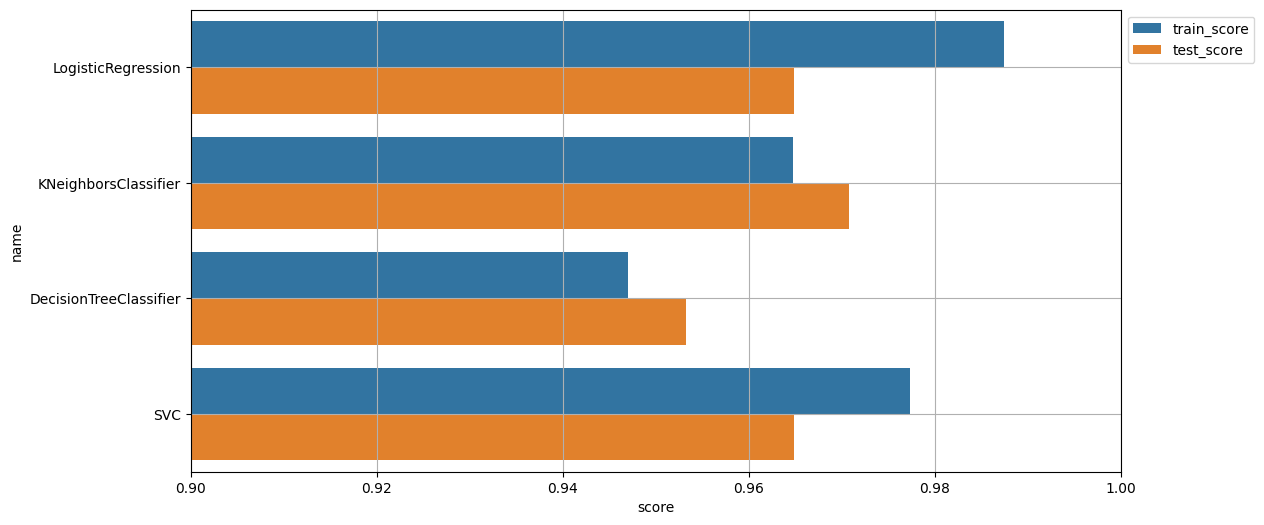

In [11]:
from matplotlib import pyplot as plt
import seaborn as sb
plt.figure(figsize=(12,6))
sb.barplot(data=df2, x='score', y='name', hue='type')
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.xlim(0.9, 1.0)  # x축 조정을 통한 그래프 값 비교
plt.show()
plt.close()